<a href="https://colab.research.google.com/github/holysantaa/reba-ai-colab/blob/main/MoveNet_REBA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# ✅ 1. 설치
!pip install -q tensorflow tensorflow-hub opencv-python

# ✅ 2. 라이브러리 임포트
import tensorflow as tf
import tensorflow_hub as hub
import cv2
import numpy as np
import matplotlib.pyplot as plt

# ✅ 3. MoveNet Thunder 로드
model = hub.load("https://tfhub.dev/google/movenet/singlepose/thunder/4")
movenet = model.signatures['serving_default']



Saving reba1.png to reba1 (1).png


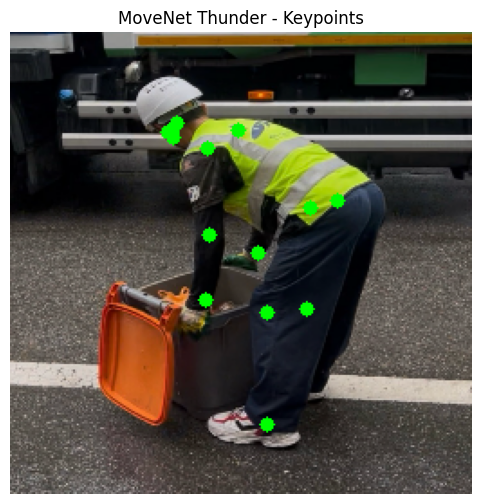

Keypoint 0: x=0.355, y=0.230, confidence=0.46
Keypoint 1: x=0.340, y=0.215, confidence=0.48
Keypoint 2: x=0.353, y=0.208, confidence=0.48
Keypoint 3: x=0.361, y=0.196, confidence=0.56
Keypoint 4: x=0.409, y=0.167, confidence=0.28
Keypoint 5: x=0.428, y=0.253, confidence=0.74
Keypoint 6: x=0.494, y=0.213, confidence=0.59
Keypoint 7: x=0.433, y=0.440, confidence=0.41
Keypoint 8: x=0.543, y=0.359, confidence=0.24
Keypoint 9: x=0.422, y=0.580, confidence=0.50
Keypoint 10: x=0.536, y=0.477, confidence=0.39
Keypoint 11: x=0.651, y=0.379, confidence=0.65
Keypoint 12: x=0.710, y=0.366, confidence=0.75
Keypoint 13: x=0.558, y=0.609, confidence=0.62
Keypoint 14: x=0.644, y=0.601, confidence=0.57
Keypoint 15: x=0.557, y=0.851, confidence=0.69
Keypoint 16: x=0.580, y=0.806, confidence=0.25


In [3]:
# ✅ 4. 이미지 업로드
from google.colab import files
uploaded = files.upload()

# 업로드한 이미지 읽기
for fn in uploaded.keys():
    image_path = fn

# ✅ 5. 이미지 전처리
def load_image(path):
    image = tf.io.read_file(path)
    image = tf.image.decode_image(image, channels=3)  # 🔧 수정된 부분
    image = tf.image.resize_with_pad(image, 256, 256)
    input_image = tf.expand_dims(image, axis=0)
    input_image = tf.cast(input_image, dtype=tf.int32)
    return input_image, image

input_image, display_image = load_image(image_path)

# ✅ 6. 관절 추출
outputs = movenet(input_image)
keypoints = outputs['output_0'].numpy()[0, 0, :, :]

# ✅ 7. 시각화 함수
def draw_keypoints(image, keypoints):
    h, w, _ = image.shape
    for kp in keypoints:
        y, x, c = kp
        if c > 0.3:  # 신뢰도 30% 이상만 표시
            cv2.circle(image, (int(x * w), int(y * h)), 4, (0, 255, 0), -1)
    return image

# 이미지 복사 후 키포인트 표시
img = cv2.imread(image_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (256, 256))
out_img = draw_keypoints(img.copy(), keypoints)

# ✅ 8. 시각화 출력
plt.figure(figsize=(6,6))
plt.imshow(out_img)
plt.title("MoveNet Thunder - Keypoints")
plt.axis('off')
plt.show()

# ✅ 9. 관절 좌표 출력
for i, (y, x, c) in enumerate(keypoints):
    print(f"Keypoint {i}: x={x:.3f}, y={y:.3f}, confidence={c:.2f}")


In [6]:
import numpy as np

# ✅ 각도 계산 함수
def calculate_angle(a, b, c):
    a = np.array(a)
    b = np.array(b)
    c = np.array(c)
    ba = a - b
    bc = c - b
    cosine_angle = np.dot(ba, bc) / (np.linalg.norm(ba) * np.linalg.norm(bc))
    angle = np.arccos(np.clip(cosine_angle, -1.0, 1.0))
    return np.degrees(angle)

# 키포인트 이름 목록
keypoint_names = [
    'nose', 'left_eye', 'right_eye', 'left_ear', 'right_ear',
    'left_shoulder', 'right_shoulder', 'left_elbow', 'right_elbow',
    'left_wrist', 'right_wrist', 'left_hip', 'right_hip',
    'left_knee', 'right_knee', 'left_ankle', 'right_ankle'
]

# 이름 기반 딕셔너리 구성
keypoints_dict = {name: keypoints[i][:2] for i, name in enumerate(keypoint_names)}

# 관절 설정 (왼쪽 기준 사용)
L_shoulder = keypoints_dict['left_shoulder']
L_elbow    = keypoints_dict['left_elbow']
L_wrist    = keypoints_dict['left_wrist']
L_hip      = keypoints_dict['left_hip']
L_knee     = keypoints_dict['left_knee']
L_ankle    = keypoints_dict['left_ankle']

# ✅ 관절 각도 계산
elbow_angle = calculate_angle(L_shoulder, L_elbow, L_wrist)
knee_angle = calculate_angle(L_hip, L_knee, L_ankle)
waist_angle = calculate_angle(L_shoulder, L_hip, L_knee)
upper_arm_angle = calculate_angle(L_hip, L_shoulder, L_elbow)
wrist_angle = calculate_angle(L_elbow, L_wrist, [L_wrist[0]+0.1, L_wrist[1]])  # 대략적인 방향 추정

print(f"팔꿈치 각도: {elbow_angle:.2f}°")
print(f"무릎 각도: {knee_angle:.2f}°")
print(f"허리 굽힘 각도: {waist_angle:.2f}°")
print(f"윗팔 굽힘 각도: {upper_arm_angle:.2f}°")

# ✅ 사용자 입력
weight_kg = float(input("물체 무게 (kg): "))
sudden_force = input("충격적/급작스런 힘 사용? (y/n): ").lower() == "y"
grip_quality = input("손잡이 품질? (good / fair / poor / none): ").lower()

# ✅ 점수화 함수
def trunk_score(angle):
    if angle < 5:
        return 1
    elif angle < 20:
        return 2
    elif angle < 60:
        return 3
    else:
        return 4

def neck_score(): return 2  # 수동 설정 또는 angle 기반 개선 가능
def leg_score(knee_angle): return 1 if knee_angle > 90 else 2
def upper_arm_score(angle):
    if angle > 120: return 6
    elif angle > 90: return 4
    elif angle > 60: return 3
    else: return 2
def lower_arm_score(angle): return 1 if 60 <= angle <= 100 else 2
def wrist_score(angle): return 2 if angle > 15 else 1

# ✅ 부하/손잡이 점수 함수
def load_score(weight_kg, sudden=False):
    score = 0
    if weight_kg >= 10:
        score = 2
    elif weight_kg >= 5:
        score = 1
    if sudden:
        score += 1
    return score

def coupling_score(quality):
    table = {"good": 0, "fair": 1, "poor": 2, "none": 3}
    return table.get(quality, 0)

# ✅ 관절 기반 점수 계산
trunk = trunk_score(waist_angle)
neck = neck_score()
leg = leg_score(knee_angle)
upper_arm = upper_arm_score(upper_arm_angle)
lower_arm = lower_arm_score(elbow_angle)
wrist = wrist_score(wrist_angle)

# ✅ 그룹 A 테이블
def get_A_score(trunk, neck, leg):
    A_table = [
        [[1, 2, 3, 4], [1, 2, 3, 4], [1, 2, 3, 4]],
        [[2, 3, 4, 5], [3, 4, 5, 6], [4, 5, 6, 7]],
        [[2, 4, 5, 6], [3, 5, 6, 7], [4, 6, 7, 8]],
        [[3, 5, 6, 7], [4, 6, 7, 8], [5, 7, 8, 9]],
        [[4, 6, 7, 8], [5, 7, 8, 9], [6, 8, 9, 9]],
    ]
    return A_table[trunk-1][neck-1][leg-1]

# ✅ 그룹 B 테이블
def get_B_score(upper_arm, lower_arm, wrist):
    B_table = [
        [[1, 2, 2], [1, 2, 3], [3, 4, 5], [4, 5, 6], [6, 7, 8], [7, 8, 8]],
        [[1, 2, 3], [2, 3, 4], [4, 5, 5], [5, 6, 7], [7, 8, 8], [8, 9, 9]],
    ]
    return B_table[lower_arm-1][upper_arm-1][wrist-1]

# ✅ 그룹 C (REBA 최종 점수 테이블)
REBA_C_table = [
    [1, 1, 1, 1, 2, 3, 3, 4, 5, 6, 7, 7],
    [1, 2, 2, 2, 3, 4, 4, 5, 6, 6, 7, 8],
    [2, 2, 3, 3, 3, 4, 5, 6, 7, 7, 8, 8],
    [3, 3, 4, 4, 4, 5, 6, 7, 8, 8, 9, 9],
    [4, 4, 4, 4, 5, 6, 7, 8, 9, 9, 9, 9],
    [6, 6, 6, 6, 7, 8, 8, 9, 10, 10, 10, 10],
    [7, 7, 7, 7, 8, 9, 9, 10, 11, 11, 11, 11],
    [8, 8, 8, 8, 9, 10, 10, 10, 10, 11, 11, 11],
    [9, 9, 9, 9, 10, 10, 10, 10, 10, 11, 11, 11],
    [10, 10, 10, 10, 11, 11, 11, 12, 12, 12, 12, 12],
    [11, 11, 11, 11, 11, 12, 12, 12, 12, 12, 12, 12],
    [12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12]
]

# ✅ 그룹 A/B/C 점수 계산
A_base = get_A_score(trunk, neck, leg)
A = A_base + load_score(weight_kg, sudden_force)
B_base = get_B_score(upper_arm, lower_arm, wrist)
B = B_base + coupling_score(grip_quality)

# ✅ 최종 점수
final_score = REBA_C_table[min(A-1,11)][min(B-1,11)]  # 점수 범위 초과 방지

# ✅ 출력
print("\n==== REBA 점수 상세 (공식 + 사용자 입력 반영) ====")
print(f"Trunk 점수: {trunk} / Neck 점수: {neck} / Leg 점수: {leg} → 그룹 A 점수: {A_base} + 부하 보정 = {A}")
print(f"Upper: {upper_arm} / Lower: {lower_arm} / Wrist: {wrist} → 그룹 B 점수: {B_base} + 손잡이 보정 = {B}")
print(f"▶ 최종 REBA 점수 (그룹 C): {final_score}")


팔꿈치 각도: 173.84°
무릎 각도: 158.16°
허리 굽힘 각도: 97.20°
윗팔 굽힘 각도: 58.98°
물체 무게 (kg): 4
충격적/급작스런 힘 사용? (y/n): y
손잡이 품질? (good / fair / poor / none): poor

==== REBA 점수 상세 (공식 + 사용자 입력 반영) ====
Trunk 점수: 4 / Neck 점수: 2 / Leg 점수: 1 → 그룹 A 점수: 4 + 부하 보정 = 5
Upper: 2 / Lower: 2 / Wrist: 2 → 그룹 B 점수: 3 + 손잡이 보정 = 5
▶ 최종 REBA 점수 (그룹 C): 5
